# Exploration 18. OCR

## Keras-ocr
`keras-ocr`은 텐서플로우의 케라스 API를 기반으로 이미지 속 문자를 읽는 End-to-End OCR을 할 수 있게 한다.  

`keras_ocr.pipeline.Pipeline()` 는 인식을 위한 파이프라인을 생성하는데 이때 초기화 과정에서 미리 학습된 모델의 가중치(weight)를 불러온다.

검출기(detection)와 인식기(recognition)를 위한 가중치 하나씩을 불러온다.

In [1]:
import matplotlib.pyplot as plt
import keras_ocr

# keras-ocr이 detector과 recognizer를 위한 모델을 자동으로 다운로드받게 됩니다. 
pipeline = keras_ocr.pipeline.Pipeline()

Looking for /aiffel/.keras-ocr/craft_mlt_25k.h5
Looking for /aiffel/.keras-ocr/crnn_kurapan.h5


만들어둔 파이프라인의 recognize() 에 이미지를 넣는다.

In [2]:
# 테스트에 사용할 이미지 url을 모아 봅니다. 추가로 더 모아볼 수도 있습니다. 
image_urls = [
  'https://source.unsplash.com/M7mu6jXlcns/640x460',
  'https://source.unsplash.com/6jsp4iHc8hI/640x460',
  'https://source.unsplash.com/98uYQ-KupiE',
  'https://source.unsplash.com/j9JoYpaJH3A',
  'https://source.unsplash.com/eBkEJ9cH5b4'
]

images = [ keras_ocr.tools.read(url) for url in image_urls]
prediction_groups = [pipeline.recognize([url]) for url in image_urls]

인식된 결과를 pyplot으로 시각화한다.

/opt/conda/lib/python3.7/site-packages/keras_ocr/tools.py:166: MatplotlibDeprecationWarning: The 's' parameter of annotate() has been renamed 'text' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  horizontalalignment='right' if side == 'left' else 'left')


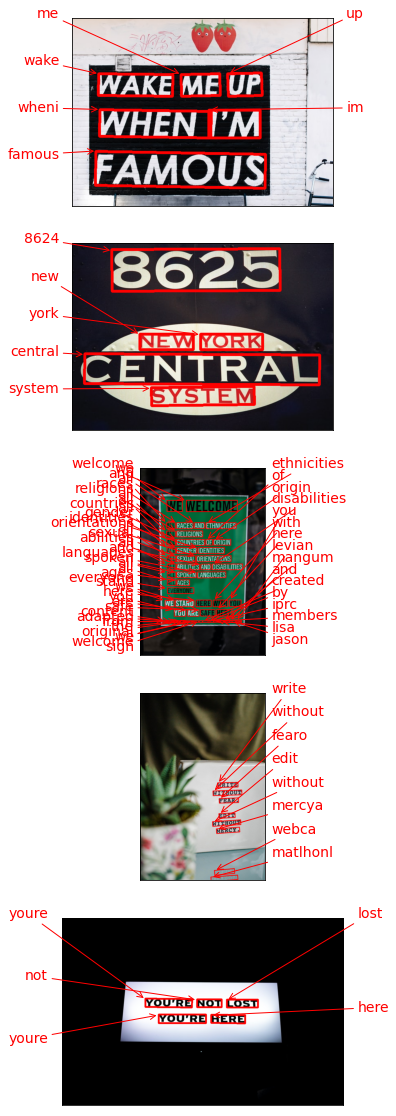

In [3]:
# Plot the predictions
fig, axs = plt.subplots(nrows=len(images), figsize=(20, 20))
for idx, ax in enumerate(axs):
    keras_ocr.tools.drawAnnotations(image=images[idx], 
                                    predictions=prediction_groups[idx][0], ax=ax)

`keras-ocr`은 한글 데이터셋으로 훈련이 되어있지 않은 모델이다. 한글 텍스트의 detection은 정상적으로 진행되더라도 recognition 결과가 이상하게 나올 수 있다.

----

## Tesseract OCR
테서랙트는 구글에서 후원하는 OCR 오픈소스 라이브러리로 현재는 버전 4와 Tesseract.js등으로 확장되는 등 많은 곳에서 사용되고 있다. 버전 4에서는 LSTM이 엔진에 추가되었고 현재 한국어를 포함한 116 개 국어를 지원하고 있다.

### 1. 테서랙트 설치
```
$ sudo apt install tesseract-ocr
$ sudo apt install libtesseract-dev
```

### 2. 테서랙트 파이썬 wrapper 설치
Pytesseract는 OS에 설치된 테서랙트를 파이썬에서 쉽게 사용할 수 있도록 해주는 래퍼 라이브러리(wrapper library)이다.  
파이썬 내에서 컴퓨터에 설치된 테서랙트 엔진의 기능을 바로 쓸 수 있도록 해준다.
```
$ pip install pytesseract
```

### 3. 테서랙트로 문자 검출하고 이미지 자르기 (detection) 

테서랙트를 사용하면 한 번에 이미지 내의 문자 검출과 인식을 할 수 있는데, OCR이 이뤄지는 전체 과정을 직접 거쳐보기 위해 검출을 먼저 해보자.

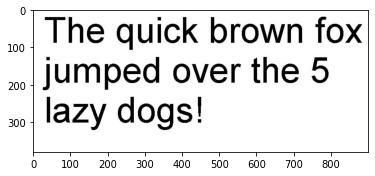

/aiffel/aiffel/ocr_python/eng_0000.png
/aiffel/aiffel/ocr_python/eng_0001.png
/aiffel/aiffel/ocr_python/eng_0002.png
/aiffel/aiffel/ocr_python/eng_0003.png
/aiffel/aiffel/ocr_python/eng_0004.png
/aiffel/aiffel/ocr_python/eng_0005.png
/aiffel/aiffel/ocr_python/eng_0006.png
/aiffel/aiffel/ocr_python/eng_0007.png
/aiffel/aiffel/ocr_python/eng_0008.png
/aiffel/aiffel/ocr_python/eng_0009.png


In [4]:
import os
import pytesseract
from PIL import Image
import cv2
from pytesseract import Output
import matplotlib.pyplot as plt

# OCR Engine modes(–oem):
# 0 - Legacy engine only.
# 1 - Neural nets LSTM engine only.
# 2 - Legacy + LSTM engines.
# 3 - Default, based on what is available.

# Page segmentation modes(–psm):
# 0 - Orientation and script detection (OSD) only.
# 1 - Automatic page segmentation with OSD.
# 2 - Automatic page segmentation, but no OSD, or OCR.
# 3 - Fully automatic page segmentation, but no OSD. (Default)
# 4 - Assume a single column of text of variable sizes.
# 5 - Assume a single uniform block of vertically aligned text.
# 6 - Assume a single uniform block of text.
# 7 - Treat the image as a single text line.
# 8 - Treat the image as a single word.
# 9 - Treat the image as a single word in a circle.
# 10 - Treat the image as a single character.
# 11 - Sparse text. Find as much text as possible in no particular order.
# 12 - Sparse text with OSD.
# 13 - Raw line. Treat the image as a single text line, bypassing hacks that are Tesseract-specific.

def crop_word_regions(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='eng',    # 한국어라면 lang='kor'
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"eng_{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/test_image_eng.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 
img_bgr = cv2.imread(img_file_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()




cropped_image_path_list = crop_word_regions(img_file_path, work_dir)

위에서 구현한 `crop_word_regions()` 함수는 테스트 이미지를 받아서, 문자 검출을 진행한 후, 검출된 문자 영역을 crop한 이미지로 만들어 그 파일들의 list를 리턴하는 함수이다.  


기본적으로 `pytesseract.image_to_data()` 를 사용한다. 파이썬에서 편하게 사용하기 위해서 `pytesseract`의 `Output`을 사용해서 결과값의 형식을 딕셔너리 형식으로 설정하게 도니다. 이렇게 인식된 결과는 바운딩 박스의 left top(x,y), width, height 정보를 가지게 된다.  
바운딩 박스를 사용해 이미지의 문자 영역들을 파이썬 `PIL(pillow)` 또는 `opencv` 라이브러리를 사용해 잘라(crop)하여 `cropped_image_path_list` 에 담아 리턴하였다.

### 4. 테서랙트로 잘린 이미지에서 단어 인식
검출된 바운딩 박스 별로 잘린 이미지를 넣어주면 영역별 텍스트가 결과값으로 나오는 `image_to_string` 을 사용한다.

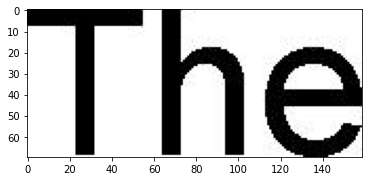

Tne



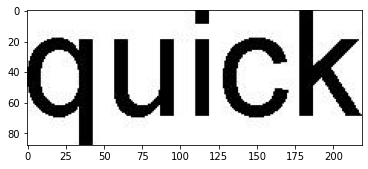

QUICK



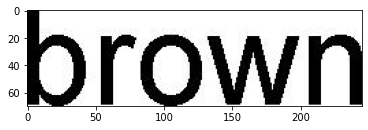

Drown



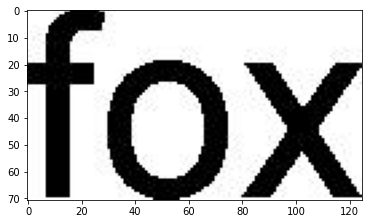

TOX



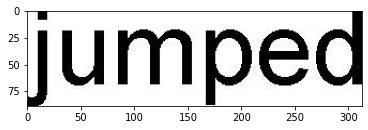

Jumped



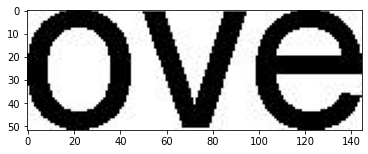

OVE



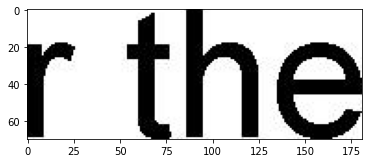

rtne



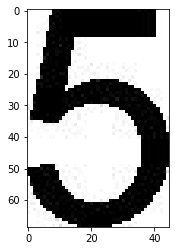

5



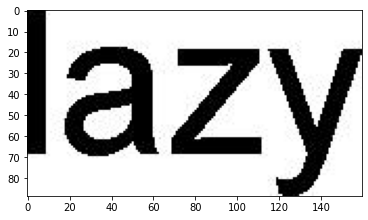

lazy



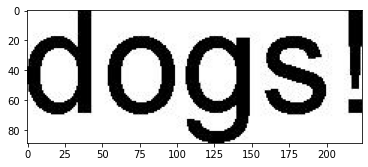

dogs!

Done


In [5]:
def recognize_images(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='eng',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        
        import cv2
        img_bgr = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.show()
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images(cropped_image_path_list)

### 5. 한국어 테스트  

`lang='kor'` 로 설정한다.

한국어를 사용하여면 테서렉트의 언어팩을 설치해야한다.
```
sudo apt install tesseract-ocr-kor
```

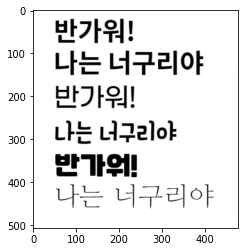

/aiffel/aiffel/ocr_python/kor_0000.png
/aiffel/aiffel/ocr_python/kor_0001.png
/aiffel/aiffel/ocr_python/kor_0002.png
/aiffel/aiffel/ocr_python/kor_0003.png
/aiffel/aiffel/ocr_python/kor_0004.png
/aiffel/aiffel/ocr_python/kor_0005.png
/aiffel/aiffel/ocr_python/kor_0006.png
/aiffel/aiffel/ocr_python/kor_0007.png
/aiffel/aiffel/ocr_python/kor_0008.png
/aiffel/aiffel/ocr_python/kor_0009.png
/aiffel/aiffel/ocr_python/kor_0010.png
/aiffel/aiffel/ocr_python/kor_0011.png
/aiffel/aiffel/ocr_python/kor_0012.png
/aiffel/aiffel/ocr_python/kor_0013.png
/aiffel/aiffel/ocr_python/kor_0014.png
/aiffel/aiffel/ocr_python/kor_0015.png
/aiffel/aiffel/ocr_python/kor_0016.png
/aiffel/aiffel/ocr_python/kor_0017.png
/aiffel/aiffel/ocr_python/kor_0018.png
/aiffel/aiffel/ocr_python/kor_0019.png


In [6]:
def crop_word_regions_kor(image_path='./images/sample.png', output_path='./output'):
    if not os.path.exists(output_path):
        os.mkdir(output_path)
    custom_oem_psm_config = r'--oem 3 --psm 3'
    image = Image.open(image_path)

    recognized_data = pytesseract.image_to_data(
        image, lang='kor',    
        config=custom_oem_psm_config,
        output_type=Output.DICT
    )
    
    top_level = max(recognized_data['level'])
    index = 0
    cropped_image_path_list = []
    for i in range(len(recognized_data['level'])):
        level = recognized_data['level'][i]
    
        if level == top_level:
            left = recognized_data['left'][i]
            top = recognized_data['top'][i]
            width = recognized_data['width'][i]
            height = recognized_data['height'][i]
            
            output_img_path = os.path.join(output_path, f"kor_{str(index).zfill(4)}.png")
            print(output_img_path)
            cropped_image = image.crop((
                left,
                top,
                left+width,
                top+height
            ))
            cropped_image.save(output_img_path)
            cropped_image_path_list.append(output_img_path)
            index += 1
    return cropped_image_path_list


work_dir = os.getenv('HOME')+'/aiffel/ocr_python'
img_file_path = work_dir + '/test_image_kor.png'   #테스트용 이미지 경로입니다. 본인이 선택한 파일명으로 바꿔주세요. 
img_bgr = cv2.imread(img_file_path)
img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(img_rgb)
plt.show()




cropped_image_path_list = crop_word_regions_kor(img_file_path, work_dir)

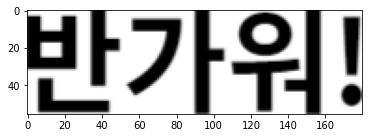

반가워!



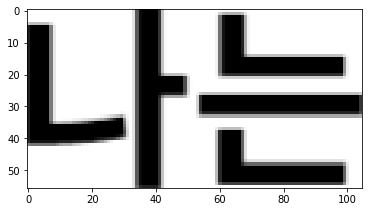

나는



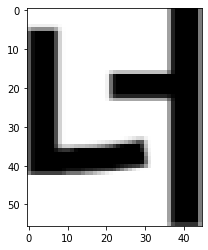

너



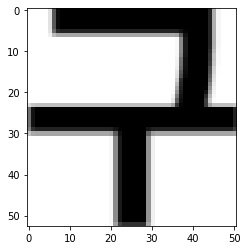

-균



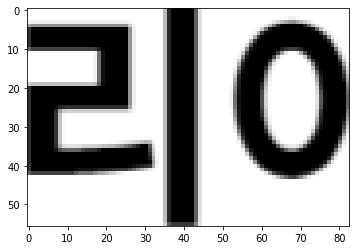

210



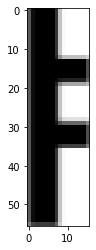

|



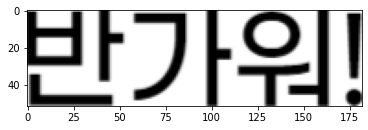

머위!



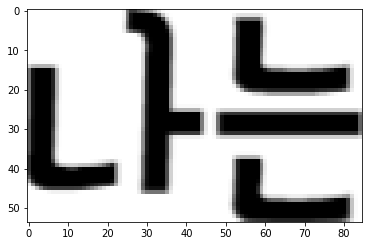

나는



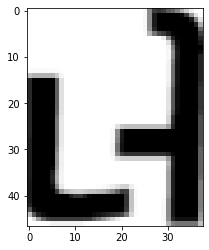

=



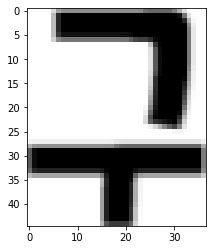

그



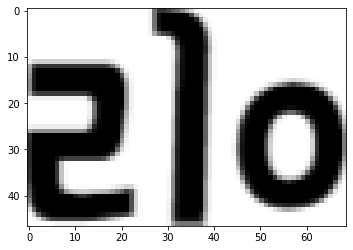

316



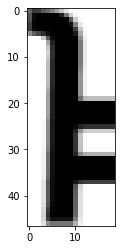

[



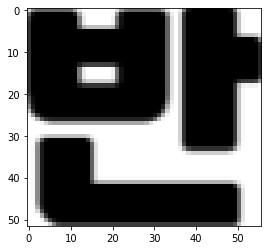

그



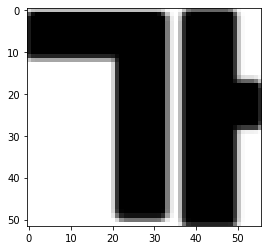

가



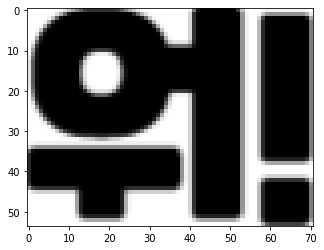

의!



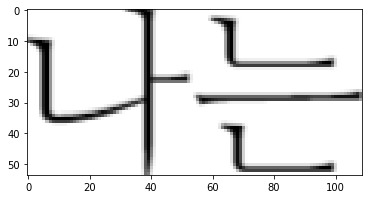

나는



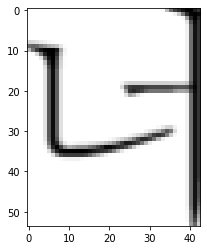

년



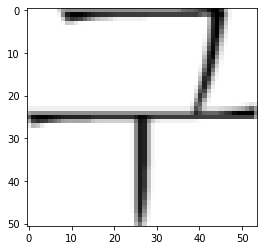

-…



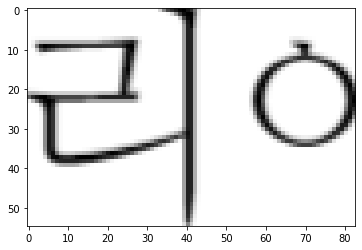

218



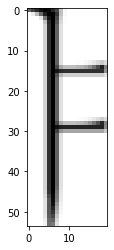

「

Done


In [7]:
def recognize_images_kor(cropped_image_path_list):
    custom_oem_psm_config = r'--oem 3 --psm 7'
    
    for image_path in cropped_image_path_list:
        image = Image.open(image_path)
        recognized_data = pytesseract.image_to_string(
            image, lang='kor',    # 한국어라면 lang='kor'
            config=custom_oem_psm_config,
            output_type=Output.DICT
        )
        
        import cv2
        img_bgr = cv2.imread(image_path)
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
        plt.imshow(img_rgb)
        plt.show()
        print(recognized_data['text'])
    print("Done")

# 위에서 준비한 문자 영역 파일들을 인식하여 얻어진 텍스트를 출력합니다.
recognize_images_kor(cropped_image_path_list)